### This Notebook includes our Boosting models

## Outline

* [Packages](#Packages)
* [Functions](#Functions)
* [Data Import and Transformation](#Data-Import-and-Transformation)
* [Gradient Boost Modeling and Hyperparametertuning](#Gradient-Boost-Modeling-and-Hyperparametertuning)
* [Interpretation of Gradient Boost & Performance](#Interpretation-gb)
* [The effect of race on our target](#effect-race)
* [Predicting Recidivism without race](#predicting-race)
* [Predict race based on the data](#predicting-race-data)
* [Final Statement](#final-statement)
* [Appendix](#app)


### <a name="Packages"></a>Packages 

In [347]:
import pandas as pd
import numpy as np 
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier 
from sklearn.inspection import partial_dependence, plot_partial_dependence, PartialDependenceDisplay
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

### <a name="Functions"></a>Functions

In [ ]:
# defining a function for the accuracy score, confusion matrix and FPR,FNR,TPR & TNR
def confusionmatrix(model, X_test, y_test, y_pred):
    conf_mat_log = plot_confusion_matrix(model,
                     X_test,
                     y_test,
                      values_format='d',
                     display_labels=["Did not recidivise","Did recidivise"])

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    print(tn, fp, fn, tp)

    fnr = fn/(fn+tp)

    fpr = fp/(fp+tn)

    tpr = tp/(tp+fn)

    tnr = tn/(tn+fp)

    ppv = tp/(tp+fp)

    npv = tn/(tn+fn)
    
    print(f"The Accuracy is {accuracy_score(y_test, y_pred).round(2)}")
    print(f"The False-negative-rate is {np.round(fnr, 2)}")
    print(f"The False-positive-rate is {np.round(fpr, 2)}")
    print(f"The Sensitivity or True-positive-rate is {np.round(tpr, 2)}")
    print(f"The Specitivity or True-negative-rate is {np.round(tnr, 2)}")
    print(f"The Positive-predictive value or precision is {np.round(ppv, 2)}")
    print(f"The Negative-predictive value or recall is {np.round(npv, 2)}")

In [256]:
#Creating function for the rates without plotting the confusion matrix
def confusion_matrix_rate(y_test, y_pred):
    conf_mat = pd.crosstab(y_pred, y_test)

    conf_mat

    tn = conf_mat[0][0]
    fp = conf_mat[0][1]
    fn = conf_mat[1][0]
    tp = conf_mat[1][1]

    print(tp, tn, fp, fn)

    fnr = fn/(fn+tp)

    fpr = fp/(fp+tn)

    tpr = tp/(tp+fn)

    tnr = tn/(tn+fp)

    ppv = tp/(tp+fp)

    npv = tn/(tn+fn)

    print(f"The False-negative-rate is {np.round(fnr, 2)}")
    print(f"The False-positive-rate is {np.round(fpr, 2)}")
    print(f"The Sensitivity or True-positive-rate is {np.round(tpr, 2)}")
    print(f"The Specitivity or True-negative-rate is {np.round(tnr, 2)}")
    print(f"The Positive-predictive value or precision is {np.round(ppv, 2)}")
    print(f"The Negative-predictive value or recall is {np.round(npv, 2)}")
    print(f"The Accuracy is {accuracy_score(y_test, y_pred).round(2)}")

### <a name="Data-Import-and-Transformation"></a>Data Import and Transformation 


First we import our csv that we created in the preprocessing step

In [342]:
df = pd.read_csv(r"C:\Users\erics\OneDrive\Dokumente\MASTER HWR\Data Science\Project\df_for_modeling_no_dummies (1).csv", index_col=0)
df.head()

,is_recid,is_violent_recid,sex,race,age,juv_fel_count,juv_misd_count,juv_other_count,marital_status,highest_degree_charged,count_deg_0,count_deg_1,count_deg_2,count_deg_3,count_deg_4,count_deg_5,total_prior_charges,max_charge_incid,ear_charge_age,two_year_recid
0,0,0,Male,Other,69,0,0,0,Single,3,4,0,1,1,0,0,6,2,62,0
1,1,1,Male,African-American,34,0,0,0,Single,3,0,0,0,1,0,0,1,1,31,1
2,1,0,Male,African-American,24,0,0,1,Single,3,6,3,6,4,0,0,19,5,17,1
5,0,0,Male,Other,44,0,0,0,Separated,2,0,0,1,0,0,0,1,1,42,0
6,1,0,Male,Caucasian,41,0,0,0,Single,4,4,3,4,13,3,0,27,4,19,1


In [304]:
ratio_recid = df.groupby("two_year_recid")["two_year_recid"].count()

print(f" In total our amount of recidivised and non-recidivised people, looks as follows: \n {ratio_recid}")

 In total our amount of recidivised and non-recidivised people, looks as follows: 
 two_year_recid
0    3365
1    2856
Name: two_year_recid, dtype: int64


Transforming the object variables into int8

In [305]:
df.columns

Index(['is_recid', 'is_violent_recid', 'sex', 'race', 'age', 'juv_fel_count',
       'juv_misd_count', 'juv_other_count', 'marital_status',
       'highest_degree_charged', 'count_deg_0', 'count_deg_1', 'count_deg_2',
       'count_deg_3', 'count_deg_4', 'count_deg_5', 'total_prior_charges',
       'max_charge_incid', 'ear_charge_age', 'two_year_recid'],
      dtype='object')

To fit our Boosting models, we will turn the columns "sex", "maritial status" and "race" into type Category and code them from text to number.

In [306]:
df["sex"] = df["sex"].astype('category')
df["race"] = df["race"].astype('category')
df["marital_status"] = df["marital_status"].astype('category')

In [307]:
df["sex"] = df["sex"].cat.codes
df["race"] = df["race"].cat.codes
df["marital_status"] = df["marital_status"].cat.codes

Defining training and target variables

In [308]:
X = df.drop(['is_recid', 'is_violent_recid', 'two_year_recid'], axis=1)

In [309]:
y = df['two_year_recid']

How many observations from the data set have recidivated?

In [310]:
sum(y)/len(y)


0.4590901784279055

A total of 45% of the df have recidivated. We will use **stratification** to split the data into test and training data. This way the percentage of the recidivated people stay the same in both.

In [311]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [312]:
sum(y_train)/len(y_train)

0.4591639871382637

In [313]:
sum(y_test)/len(y_test)

0.4588688946015424

Prove that the stratification worked, because y_train and y_test contain the same percentage of recidivated people.

## <a name="Gradient-Boost-Modeling-and-Hyperparametertuning"></a>Gradient Boost Modeling and Hyperparametertuning

Accuracy of the GBM on test set: 0.691
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       842
           1       0.68      0.62      0.65       714

    accuracy                           0.69      1556
   macro avg       0.69      0.69      0.69      1556
weighted avg       0.69      0.69      0.69      1556



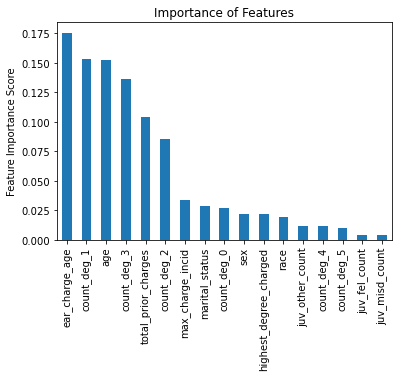

In [349]:
# Run a baseline model without tuning -> SKIP TO LAST PART CELL TO NOT RUN THE GRIDSEARCH
baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test, y_test)))
pred=baseline.predict(X_test)
print(classification_report(y_test, pred))

In [14]:
# Tunign n_estimators and Learning rate
p_test3 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750]}

tuning = GridSearchCV(estimator = GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='accuracy',n_jobs=4, cv=5)
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

KeyboardInterrupt: 

In [ ]:
# max_depth
p_test2 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.05,n_estimators=100, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test2, scoring='accuracy',n_jobs=4, cv=5)
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

Accuracy of the GBM on test set: 0.690
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       842
           1       0.68      0.62      0.65       714

    accuracy                           0.69      1556
   macro avg       0.69      0.68      0.69      1556
weighted avg       0.69      0.69      0.69      1556



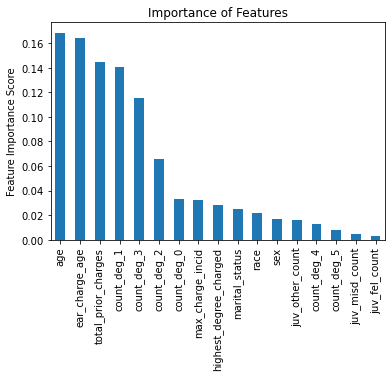

In [82]:
# First evaluation of new model on test set
baseline = GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test, y_test)))
pred=baseline.predict(X_test)
print(classification_report(y_test, pred))

We can not see a improvement in accuracy of the model yet, but there were slight changes in the feature importance as age moved to the first place.

In [ ]:
# MIN SAMPLE SPLIT AND MIN SAMPLE LEAF
p_test4 = {'min_samples_split':[2,4,6,8,10,20,40,60,100], 'min_samples_leaf':[1,3,5,7,9]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,max_depth=4, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test4, scoring='accuracy',n_jobs=4, cv=5)
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

In [ ]:
# MAX FEATURES
p_test5 = {'max_features':[2,3,4,5,6,7]}
tuning = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.01, n_estimators=100,max_depth=4, min_samples_split=20, min_samples_leaf=5, subsample=1, random_state=10), 
param_grid = p_test5, scoring='accuracy',n_jobs=4, cv=5)
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

In [ ]:
# SUBSAMPLE
p_test6= {'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,max_depth=4, min_samples_split=20, min_samples_leaf=5,max_features=4 , random_state=10), 
param_grid = p_test6, scoring='accuracy',n_jobs=4, cv=5)
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

Accuracy of the GBM on test set: 0.693
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       842
           1       0.68      0.62      0.65       714

    accuracy                           0.69      1556
   macro avg       0.69      0.69      0.69      1556
weighted avg       0.69      0.69      0.69      1556



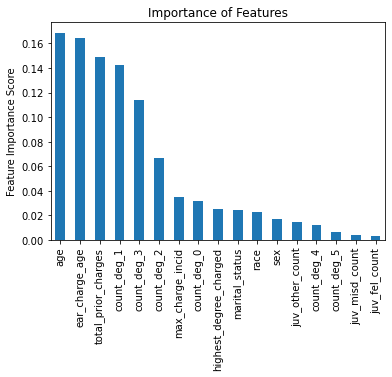

In [350]:
# Evaluation of final model on Test set
new=GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,max_depth=4, min_samples_split=20, min_samples_leaf=5,max_features=4, subsample=1, random_state=10)
new.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(new.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(new.score(X_test, y_test)))
pred=new.predict(X_test)
print(classification_report(y_test, pred))

### <a name="Interpretation-gb"></a>Interpretation of Gradient Boost & Performance

In [351]:
y_pred = new.predict(X_test)

639 203 274 440
The Accuracy is 0.69
The False-negative-rate is 0.38
The False-positive-rate is 0.24
The Sensitivity or True-positive-rate is 0.62
The Specitivity or True-negative-rate is 0.76
The Positive-predictive value or precision is 0.68
The Negative-predictive value or recall is 0.7


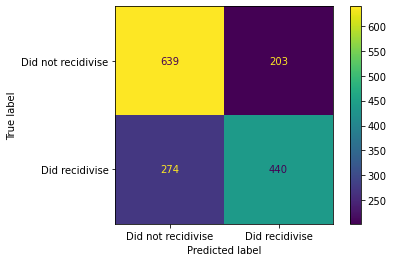

In [352]:
confusionmatrix(new, X_test, y_test, y_pred)

In the confusion matrix, we see that **842** people did not recidivise, **651 (78%)** were correctly classified. Of the **714** people that did recidivate,  **439 (61%)** were correctly classified. 

ROC Curve, AUC Curve:

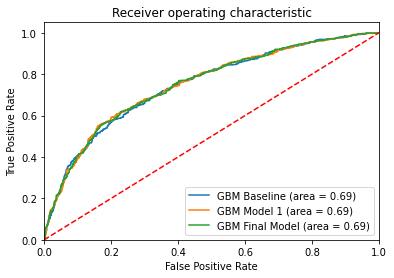

In [353]:
# Comparison of ROC AUC
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 


#run models
baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train,y_train)

model1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
model1.fit(X_train,y_train)


new=GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7,max_features=4 , subsample=0.95, random_state=10)
new.fit(X_train,y_train)

#calculate values for ROC AUC plot
#baseline model
baseline_roc_auc = roc_auc_score(y_test, baseline.predict(X_test))
fprB, tprB, thresholdsB = roc_curve(y_test, baseline.predict_proba(X_test)[:,1])
#model 1
model1_roc_auc = roc_auc_score(y_test, model1.predict(X_test))
fpr1, tpr1, thresholds1 = roc_curve(y_test, model1.predict_proba(X_test)[:,1])
#new tuned model 
new_roc_auc = roc_auc_score(y_test, new.predict(X_test))
fprnew, tprnew, thresholds_new = roc_curve(y_test, new.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fprB, tprB, label='GBM Baseline (area = %0.2f)' % baseline_roc_auc)
plt.plot(fpr1, tpr1, label='GBM Model 1 (area = %0.2f)' % model1_roc_auc)
plt.plot(fprnew, tprnew, label='GBM Final Model (area = %0.2f)' % new_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

We can only see a very slight improvement of the AUC with tuning the model.

Further Feature Importance Analysis:

In [199]:
imp_ = tun_gb.feature_importances_
imp_

array([0.01499469, 0.0162551 , 0.18273644, 0.00195089, 0.00211983,
       0.01171555, 0.01083513, 0.00331323, 0.02487176, 0.12115613,
       0.04000144, 0.08545578, 0.00964191, 0.00828714, 0.21471081,
       0.02653606, 0.22541809])

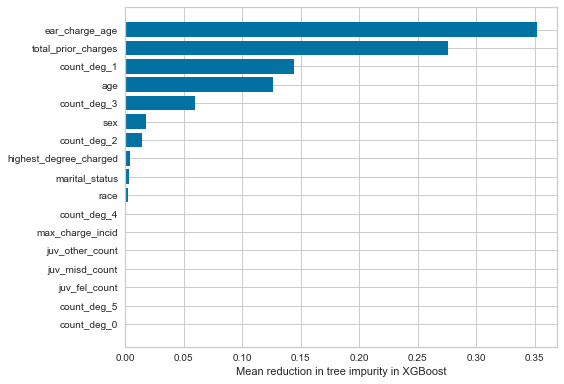

In [200]:
# Permutation feature importance
imp_df = pd.DataFrame({'feature': X_train.columns.values,
                       'importance': clf_gb.feature_importances_})
 
# Reorder by importance
ordered_df = imp_df.sort_values(by='importance')
imp_range=range(1,len(imp_df.index)+1)
 
## Barplot with confidence intervals
height = ordered_df['importance']
bars = ordered_df['feature']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Mean reduction in tree impurity in XGBoost")

plt.tight_layout()
# Show graphic
plt.show()

Evaluating Permutation feature importance, the ear_charge_age, total_prior charges and count deg 1 prove to have the highest importance in the model.

Juvenile Counts, our new variable max_charge_incid and count_degree 0,5 and 4 seem to have little to know importance.

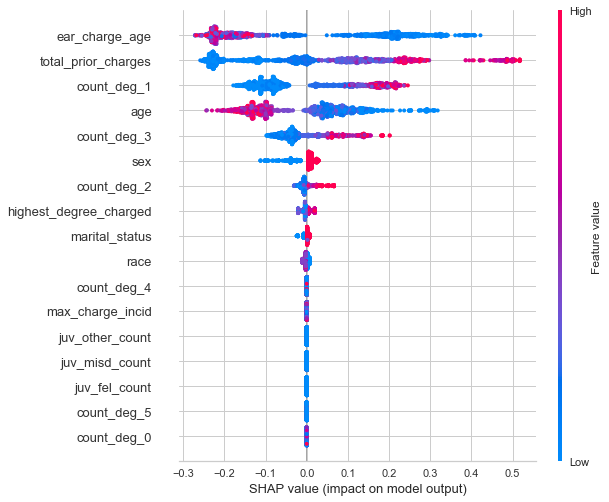

In [201]:
# Shap Feature importance
import shap
explainer = shap.TreeExplainer(clf_gb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

The shapley values confirm our findings, ear_charge_age, total prior charges and the counts within the 
degree 1 seem to be most important for our model to predict recidivism.

There is a big difference betwwen total_prior_charges and the age variables. Total_prior_charges correleates positively to our target variable, meaning that the higher the amount of charges, the more likely an observations is to recidivate. In contrast to that the age variables prove a negative correlation, meaning that younger people have an increased probability to recidivate.

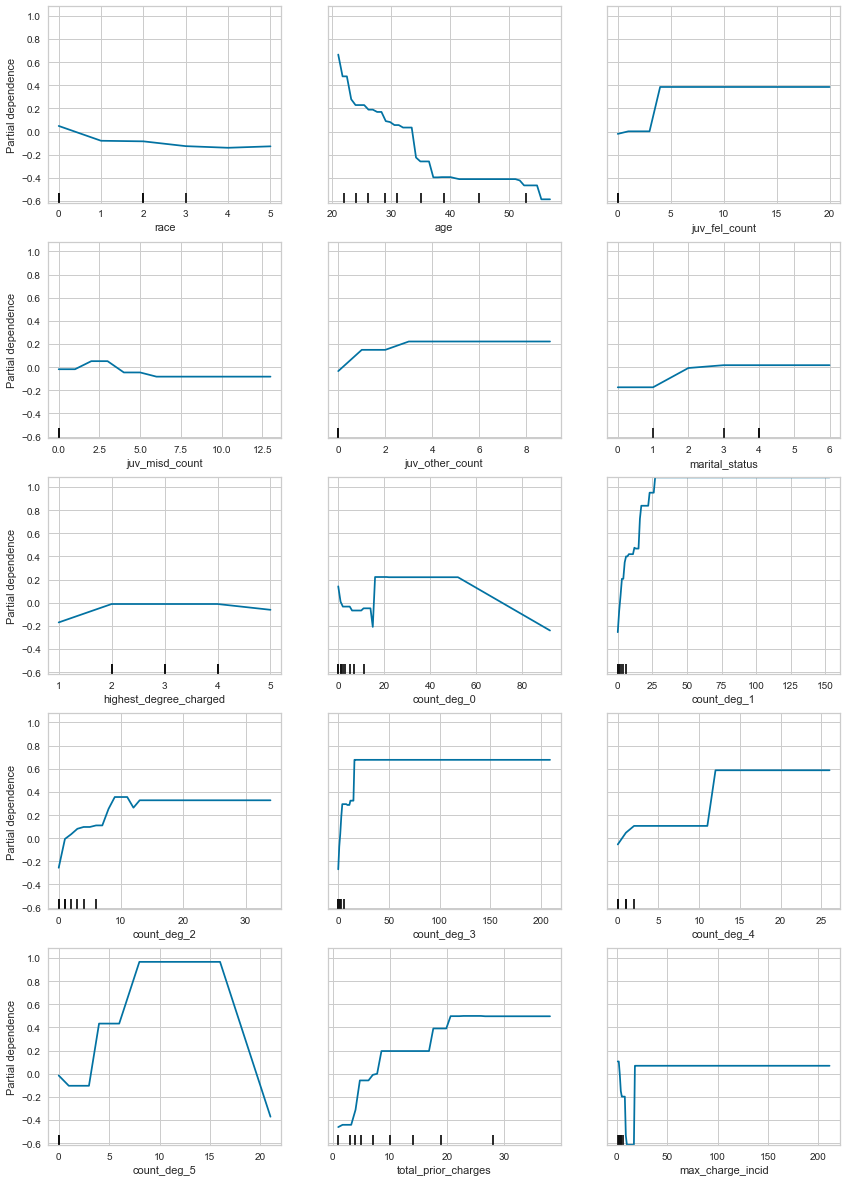

In [203]:
# Partial dependence plots
features = X_train.columns

display = plot_partial_dependence(tun_gb, X_train, features[1:16], n_jobs=11 ,grid_resolution=50, kind="average")

plt.subplots_adjust(top = 3, right = 1.5)

Interpreting the PDP:

Age -> The slope is steadily decreasing so while getting older, recidivism decreases

Count _deg 1-5 -> you can see a steep increasing slope, unfortunately on the parts where there are no instances the slope changes to 0

Other -> Other variables such as race, juvenile counts and marital status do not show a siginificant slope to interpret

The observations confirm our findings from prior feature importances.

### <a name="effect-race"></a>The effect of race on our target

In [252]:
X_test_copy = X_test.copy()

X_test_copy.head()

X_test_copy["predictions"] = y_pred #this is your actual predictions from the model not the probabilities
X_test_copy["true_values"] = y_test

X_test_copy.head()

X_test_copy.shape

X_rest = X_test_copy[(X_test_copy["race"] != 0)]

X_afr = X_test_copy[(X_test_copy["race"] == 0)]

# sanity check, the n_rows added need to equal the rows of X_test
print(X_afr.shape, X_rest.shape)

(822, 19) (734, 19)


In [319]:
# Confusion Matrix for African Americans
confusion_matrix_rate( X_afr["true_values"], X_afr["predictions"])

300 276 127 119
The False-negative-rate is 0.28
The False-positive-rate is 0.32
The Sensitivity or True-positive-rate is 0.72
The Specitivity or True-negative-rate is 0.68
The Positive-predictive value or precision is 0.7
The Negative-predictive value or recall is 0.7
The Accuracy is 0.7


In [320]:
# Confusion Matrix for non-African Americans
confusion_matrix_rate( X_rest["true_values"], X_rest["predictions"])

139 375 64 156
The False-negative-rate is 0.53
The False-positive-rate is 0.15
The Sensitivity or True-positive-rate is 0.47
The Specitivity or True-negative-rate is 0.85
The Positive-predictive value or precision is 0.68
The Negative-predictive value or recall is 0.71
The Accuracy is 0.7


### <a name="predicting-race"></a>Predicting Recidivism without race

In [294]:
# dropping race
df_new = df.drop(["race"], axis = 1)

In [295]:
# defining target and prodictor variables
X = df_new.drop(['is_recid', 'is_violent_recid', 'two_year_recid'], axis=1)
y = df_new["two_year_recid"]

In [296]:
# splitting the data into train and test data using stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
sum(y_train)/len(y_train)
sum(y_test)/len(y_test)

0.4588688946015424

In [298]:
# fitting the model
clf_no_race=GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,max_depth=4, min_samples_split=20, min_samples_leaf=5,max_features=4, subsample=1, random_state=10)
clf_no_race.fit(X_train,y_train)
y_pred = clf_no_race.predict(X_test)

640 202 284 430
The Accuracy is 0.69
The False-negative-rate is 0.4
The False-positive-rate is 0.24
The Sensitivity or True-positive-rate is 0.6
The Specitivity or True-negative-rate is 0.76
The Positive-predictive value or precision is 0.68
The Negative-predictive value or recall is 0.69


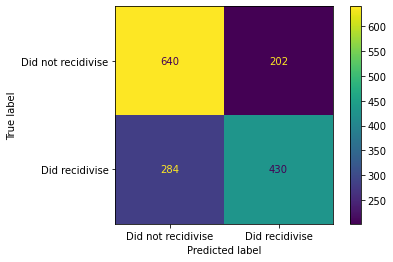

In [299]:
confusionmatrix(clf_no_race, X_test, y_test, y_pred)

We can see that the model performs almost quite as well as when it contains race as a predictor variable. 

Now let's add race back into our data frame.

In [322]:
X_test_copy2 = X_test.copy()
X_test_copy2.head()

,sex,race,age,juv_fel_count,juv_misd_count,juv_other_count,marital_status,highest_degree_charged,count_deg_0,count_deg_1,count_deg_2,count_deg_3,count_deg_4,count_deg_5,total_prior_charges,max_charge_incid,ear_charge_age
1664,0,0,24,0,0,0,4,3,0,1,0,1,0,0,2,1,19
2220,1,3,41,0,0,0,1,4,0,0,3,0,1,0,4,4,39
2023,1,0,35,0,0,0,4,2,2,2,1,0,0,0,5,2,22
1927,1,2,43,0,0,0,4,2,2,0,4,0,0,0,6,6,41
5421,1,0,27,0,0,0,4,2,4,2,1,0,0,0,7,3,20


In [323]:
X_test_copy2["race"] = X_test_copy["race"]

In [324]:
X_test_copy2.head()

,sex,race,age,juv_fel_count,juv_misd_count,juv_other_count,marital_status,highest_degree_charged,count_deg_0,count_deg_1,count_deg_2,count_deg_3,count_deg_4,count_deg_5,total_prior_charges,max_charge_incid,ear_charge_age
1664,0,0,24,0,0,0,4,3,0,1,0,1,0,0,2,1,19
2220,1,3,41,0,0,0,1,4,0,0,3,0,1,0,4,4,39
2023,1,0,35,0,0,0,4,2,2,2,1,0,0,0,5,2,22
1927,1,2,43,0,0,0,4,2,2,0,4,0,0,0,6,6,41
5421,1,0,27,0,0,0,4,2,4,2,1,0,0,0,7,3,20


In [325]:
X_test_copy2["predictions"] = y_pred
X_test_copy2["true_values"] = y_test

In [326]:
print(X_afr.shape, X_rest.shape)

(822, 19) (734, 19)


Subsetting the dataframe was succesfull.

In [327]:
# subset for race african american 

X_afr = X_test_copy2[(X_test_copy2["race"] == 0) ]

X_rest = X_test_copy2[(X_test_copy2["race"] != 0)]

In [328]:
# Confusion Matrix for African Americans

afr_conf_mat = pd.crosstab(X_afr["predictions"], X_afr["true_values"])

afr_conf_mat

true_values,0,1
predictions,,
0,273,123
1,130,296


In [330]:
# Confusion Matrix for African Americans
confusion_matrix_rate( X_afr["true_values"], X_afr["predictions"])

296 273 130 123
The False-negative-rate is 0.29
The False-positive-rate is 0.32
The Sensitivity or True-positive-rate is 0.71
The Specitivity or True-negative-rate is 0.68
The Positive-predictive value or precision is 0.69
The Negative-predictive value or recall is 0.69
The Accuracy is 0.69


In [106]:
# Confusion Matrix for non-African Americans
rest_conf_mat = pd.crosstab(X_rest["predictions"], X_rest["true_values"])

rest_conf_mat 

true_values,0,1
predictions,,
0,357,154
1,82,141


In [331]:
# Confusion Matrix for Non-African Americans
confusion_matrix_rate( X_rest["true_values"], X_rest["predictions"])

144 366 73 151
The False-negative-rate is 0.51
The False-positive-rate is 0.17
The Sensitivity or True-positive-rate is 0.49
The Specitivity or True-negative-rate is 0.83
The Positive-predictive value or precision is 0.66
The Negative-predictive value or recall is 0.71
The Accuracy is 0.69


**AFRICAN AMERICAN**

The False-negative-rate is 0.31

The False-positive-rate is 0.3

The Sensitivity or True-positive-rate is 0.69

The Specitivity or True-negative-rate is 0.7

The Positive-predictive value or precision is 0.71

The Negative-predictive value or recall is 0.69

**NON-AFRICAN AMERICAN**

The False-negative-rate is 0.52

The False-positive-rate is 0.19

The Sensitivity or True-positive-rate is 0.48

The Specitivity or True-negative-rate is 0.81

The Positive-predictive value or precision is 0.63

The Negative-predictive value or recall is 0.7


**Our findings from the previous models were confirmed.**

### <a name="predicting-race-data"></a>Predict race based on the data

Since African Americans are still more likely to be wrongfully discriminated by the model despite the model now knowing the feature during the fit, we aussme that there exist features which do are caused by the race and thus still have an impact on the model picking up the race. We therefore tried an inverse approach and tried to predict race as a binary target.

In [271]:
df["race"] = df["race"].apply(lambda x: 1 if x == 0 else 0)

In [272]:
# Assigning target and predictor variables
y_2 = df["race"]

X_2 = df.drop(['is_recid', 'is_violent_recid', 'two_year_recid', "race"], axis = 1)

In [273]:
# splitting into train and test data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_2, y_2, random_state = 42, stratify = y)

In [274]:
clf_gb = GradientBoostingClassifier(learning_rate=0.01, random_state=42)
clf_gb.fit(X_train1, y_train1)
clf_gb.predict(X_test1)

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [282]:
print(f"The predictive accuracy of the gradient boosting is: {clf_gb.score(X_test1, y_test1)}")

The predictive accuracy of the gradient boosting is: 0.6272493573264781


The False-negative-rate is 0.4
The False-positive-rate is 0.24
The Sensitivity or True-positive-rate is 0.6
The Specitivity or True-negative-rate is 0.76
The Positive-predictive value or precision is 0.68
The Negative-predictive value or recall is 0.69


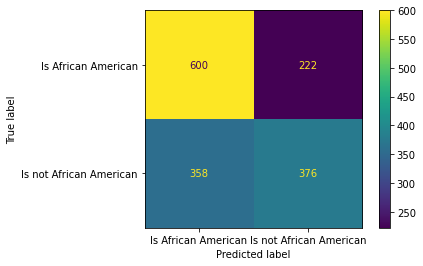

In [283]:
# confusion matrix
conf_mat_gb = plot_confusion_matrix(clf_gb,
                     X_test1,
                     y_test1,
                      values_format='d',
                     display_labels=["Is African American","Is not African American"])
fnr = fn/(fn+tp)

fpr = fp/(fp+tn)

tpr = tp/(tp+fn)

tnr = tn/(tn+fp)

ppv = tp/(tp+fp)

npv = tn/(tn+fn)

print(f"The False-negative-rate is {np.round(fnr, 2)}")
print(f"The False-positive-rate is {np.round(fpr, 2)}")
print(f"The Sensitivity or True-positive-rate is {np.round(tpr, 2)}")
print(f"The Specitivity or True-negative-rate is {np.round(tnr, 2)}")
#print(f"The Accuracy is {np.round(acc, 2)}")
print(f"The Positive-predictive value or precision is {np.round(ppv, 2)}")
print(f"The Negative-predictive value or recall is {np.round(npv, 2)}")

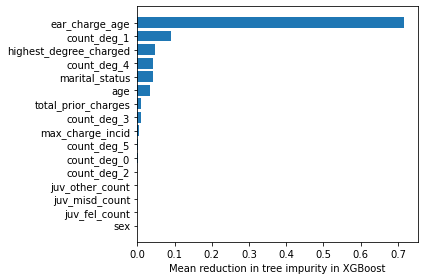

In [236]:
# Permutation feature importance
imp_df = pd.DataFrame({'feature': X_train1.columns.values,
                       'importance': clf_gb.feature_importances_})
 
# Reorder by importance
ordered_df = imp_df.sort_values(by='importance')
imp_range=range(1,len(imp_df.index)+1)
 
## Barplot with confidence intervals
height = ordered_df['importance']
bars = ordered_df['feature']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Mean reduction in tree impurity in XGBoost")

plt.tight_layout()
# Show graphic
plt.show()

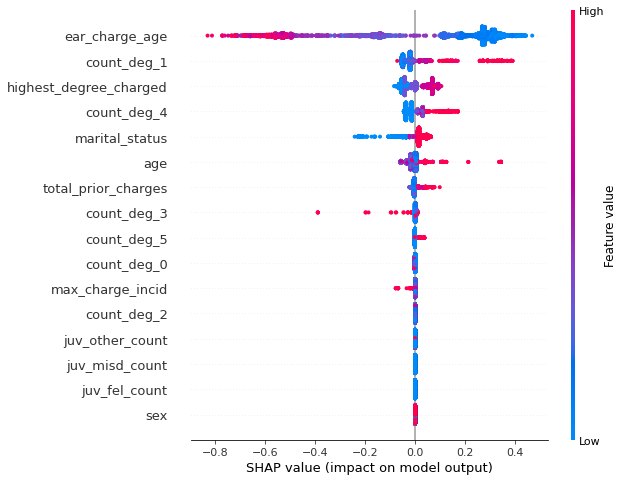

In [237]:
# Shap Feature importance
import shap
explainer = shap.TreeExplainer(clf_gb)
shap_values = explainer.shap_values(X_train1)
shap.summary_plot(shap_values, X_train1)

### <a name="final-statement"></a>Final Statement

We confirm our findings from the Linear Model notebook. We do not recommend using this data to predict on recidivism at all since it contains a level of biased that can not be erased. The future of a human being should not be determined by an algorithm since the data does not contain the wholistic information of each individual case. Complex cases should not be simplified by using features that have barely anything to do with the individual case. Therefor we find that classifying someone to recidivate should only be done by a judge / jury and not an algorithm that relies on discriminating data. 

# <a name="app"></a>Appendix

In the appendix you will find the XGBoost model. We chose to not include it because it does not achieve a higher accuracy or any other valuable insights.
They were not successfull when improving our model accuracy. 

## XGBoost (two_years_recid)

### Tuning the Hyperparameters

In [24]:
parameters = {'learning_rate':np.arange(0.001,0.5,0.1), 'n_estimators':np.arange(160), 'max_depth':np.arange(2,5,1), 'min_samples_split':np.arange(2,10,1), 'min_samples_leaf':[1]}

tuning= GridSearchCV(estimator = XGBClassifier(min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
                     param_grid =parameters, scoring = 'accuracy', n_jobs=4, cv = 5)

tuning.fit(X_train, y_train)

best_params_xgb = tuning.best_params_

C:\Users\erics\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:48:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'learning_rate': 0.201,
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 103}

In [158]:
best_params_xgb

{'learning_rate': 0.201,
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 103}

In [159]:
# Fitting the model
clf_xgb = xgb.XGBClassifier(seed=42,
                           learning_rate = 0.201,
                            max_depth = 2,
                            min_samples_leaf = 1,
                            min_samples_split = 2,
                            n_estimators = 103)                           

In [160]:
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
            early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[12:17:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.62864
[1]	validation_0-aucpr:0.65651
[2]	validation_0-aucpr:0.66886
[3]	validation_0-aucpr:0.67613
[4]	validation_0-aucpr:0.68303
[5]	validation_0-aucpr:0.68351
[6]	validation_0-aucpr:0.68512
[7]	validation_0-aucpr:0.68689
[8]	validation_0-aucpr:0.69953
[9]	validation_0-aucpr:0.70246
[10]	validation_0-aucpr:0.70151
[11]	validation_0-aucpr:0.70405
[12]	validation_0-aucpr:0.70388
[13]	validation_0-aucpr:0.70461
[14]	validation_0-aucpr:0.70644
[15]	validation_0-aucpr:0.70813
[16]	validation_0-aucpr:0.70805
[17]	validation_0-aucpr:0.70820
[18]	vali

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[43]	validation_0-aucpr:0.71398
[44]	validation_0-aucpr:0.71449
[45]	validation_0-aucpr:0.71405
[46]	validation_0-aucpr:0.71449
[47]	validation_0-aucpr:0.71510
[48]	validation_0-aucpr:0.71518
[49]	validation_0-aucpr:0.71578
[50]	validation_0-aucpr:0.71617
[51]	validation_0-aucpr:0.71519
[52]	validation_0-aucpr:0.71558
[53]	validation_0-aucpr:0.71562
[54]	validation_0-aucpr:0.71597
[55]	validation_0-aucpr:0.71568
[56]	validation_0-aucpr:0.71568
[57]	validation_0-aucpr:0.71600
[58]	validation_0-aucpr:0.71723
[59]	validation_0-aucpr:0.71756
[60]	validation_0-aucpr:0.71767
[61]	validation_0-aucpr:0.71707
[62]	validation_0-aucpr:0.71687
[63]	validation_0-aucpr:0.71660
[64]	validation_0-aucpr:0.71652
[65]	validation_0-aucpr:0.71706
[66]	validation_0-aucpr:0.71735
[67]	validation_0-aucpr:0.71715
[68]	validation_0-aucpr:0.71432
[69]	validation_0-aucpr:0.71393
[70]	validation_0-aucpr:0.71384


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.201, max_delta_step=0,
              max_depth=2, min_child_weight=1, min_samples_leaf=1,
              min_samples_split=2, missing=nan, monotone_constraints='()',
              n_estimators=103, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1, ...)

In [333]:
y_pred = clf_xgb.predict(X_test)

630 212 273 441
The Accuracy is 0.69
The False-negative-rate is 0.38
The False-positive-rate is 0.25
The Sensitivity or True-positive-rate is 0.62
The Specitivity or True-negative-rate is 0.75
The Positive-predictive value or precision is 0.68
The Negative-predictive value or recall is 0.7


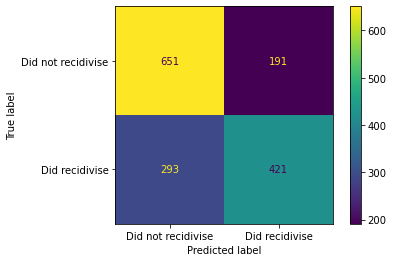

In [334]:
confusionmatrix(gb_fin, X_test_f, y_test_f, y_pred)

## Feature Importances

In [165]:
clf_xgb.feature_importances_

array([0.05290581, 0.03724103, 0.06738286, 0.0050727 , 0.01070581,
       0.03924325, 0.04820429, 0.02044125, 0.02859453, 0.13562132,
       0.05886353, 0.10605548, 0.02253752, 0.01278564, 0.1705249 ,
       0.02192317, 0.16189688], dtype=float32)

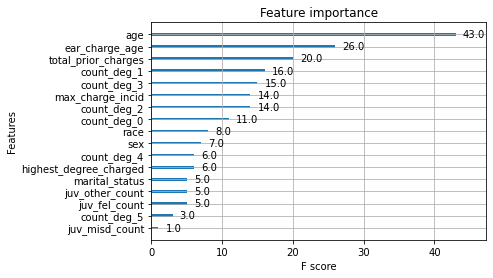

In [166]:
# XGBoost built in Feature Importances
from xgboost import plot_importance
plot_importance(clf_xgb)
plt.show()

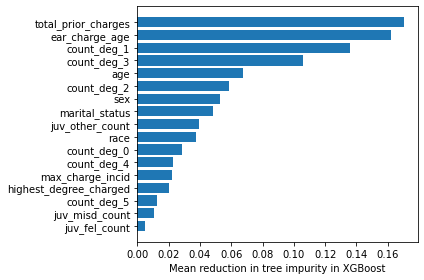

In [167]:
# Permutation feature importance
imp_df = pd.DataFrame({'feature': X_train.columns.values,
                       'importance': clf_xgb.feature_importances_})
 
# Reorder by importance
ordered_df = imp_df.sort_values(by='importance')
imp_range=range(1,len(imp_df.index)+1)
 
## Barplot with confidence intervals
height = ordered_df['importance']
bars = ordered_df['feature']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Mean reduction in tree impurity in XGBoost")

plt.tight_layout()
# Show graphic
plt.show()

Evaluating the Permutation feature importance again, it seems this time as the total_prior charges, ear_charge_age and count degrees 1,3 are important features.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


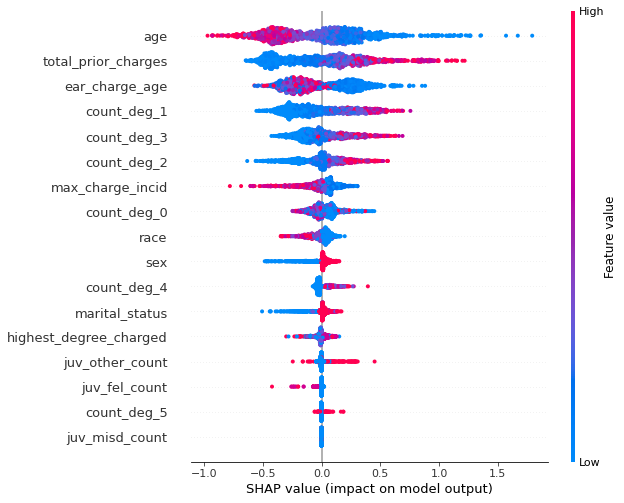

In [166]:
# Shap Feature importance
import shap
explainer = shap.TreeExplainer(clf_xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Compared to th permutation feature importance, age is here in first place.

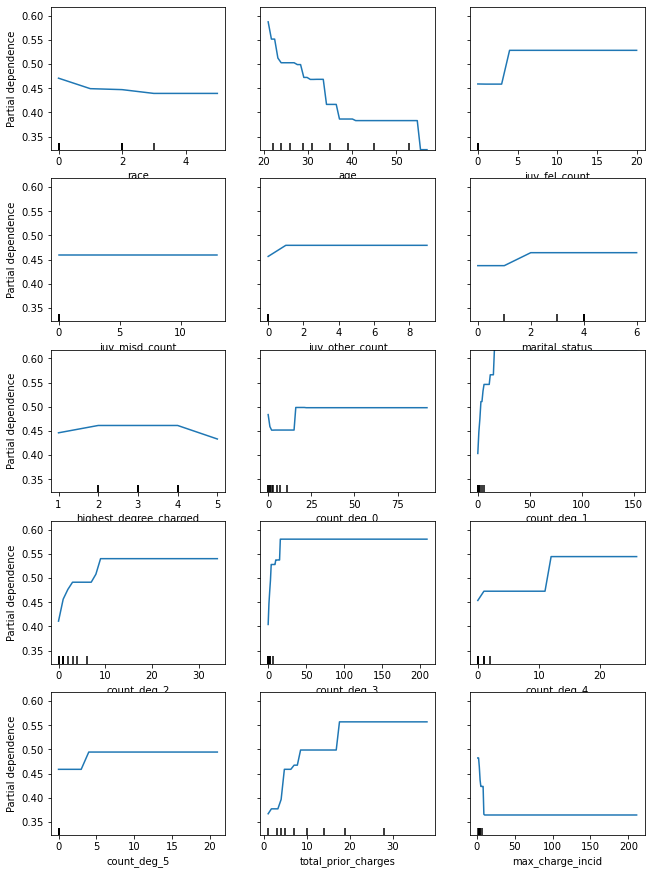

In [195]:
# Partial dependence plots
features = X_train.columns

display = plot_partial_dependence(clf_xgb, X_train, features[1:16], n_jobs=11 ,grid_resolution=50, kind="average")

plt.subplots_adjust(top = 3, right = 1.5)

Interpreting the PDP:

Age -> The slope is steadily decreasing so while getting older, recidivism decreases

Count _deg 1-5 -> you can see a steep increasing slope, unfortunately on the parts where there are no instances the slope changes to 0

Other -> Other variables such as race, juvenile counts and marital status do not show a siginificant slope to interpret

The observations confirm our findings from prior feature importances.

### BAYESON METHOD

In [178]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [179]:
#  Define objective function 
def objective(space):
    clf=XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [180]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.6465295629820051                                     
SCORE:                                                 
0.6754498714652957                                                                
  2%|▏         | 2/100 [00:00<00:06, 14.06trial/s, best loss: -0.6754498714652957]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                            
0.679305912596401                                                                 
SCORE:                                                                            
0.6323907455012854                                                               
SCORE:                                                                           
0.6741645244215938                                                               
  4%|▍         | 4/100 [00:00<00:06, 14.80trial/s, best loss: -0.679305912596401]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                           
0.6818766066838047                                                               
SCORE:                                                                            
0.6780205655526992                                                                
SCORE:                                                                            
0.679305912596401                                                                 
  8%|▊         | 8/100 [00:00<00:06, 14.38trial/s, best loss: -0.6818766066838047]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                            
0.6323907455012854                                                                
SCORE:                                                                            
0.679305912596401                                                                 
SCORE:                                                                             
0.6767352185089974                                                                 
 10%|█         | 10/100 [00:00<00:06, 14.45trial/s, best loss: -0.6818766066838047]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6748071979434447                                                                 
SCORE:                                                                             
0.6696658097686375                                                                 
SCORE:                                                                             
0.6323907455012854                                                                 
SCORE:                                                                             
0.6754498714652957                                                                 
 14%|█▍        | 14/100 [00:01<00:05, 14.71trial/s, best loss: -0.6818766066838047]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6805912596401028                                                                 
SCORE:                                                                             
0.672879177377892                                                                  
 16%|█▌        | 16/100 [00:01<00:05, 14.41trial/s, best loss: -0.6818766066838047]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6677377892030848                                                                 
SCORE:                                                                             
0.6722365038560412                                                                 
SCORE:                                                                             
0.6754498714652957                                                                 
 20%|██        | 20/100 [00:01<00:05, 14.40trial/s, best loss: -0.6818766066838047]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6818766066838047                                                                 
SCORE:                                                                             
0.6613110539845758                                                                 
SCORE:                                                                             
0.6818766066838047                                                                 
 22%|██▏       | 22/100 [00:01<00:06, 12.79trial/s, best loss: -0.6818766066838047]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6818766066838047                                                                 
SCORE:                                                                             
0.6683804627249358                                                                 
 24%|██▍       | 24/100 [00:01<00:06, 12.31trial/s, best loss: -0.6818766066838047]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6722365038560412                                                                 
SCORE:                                                                             
0.6760925449871465                                                                 
SCORE:                                                                             
0.6735218508997429                                                                 
 28%|██▊       | 28/100 [00:02<00:06, 11.35trial/s, best loss: -0.6818766066838047]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6838046272493573                                                                 
SCORE:                                                                             
0.6767352185089974                                                                 
 30%|███       | 30/100 [00:02<00:06, 11.17trial/s, best loss: -0.6838046272493573]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6773778920308483                                                                 
SCORE:                                                                             
0.6780205655526992                                                                 
 32%|███▏      | 32/100 [00:02<00:06, 10.89trial/s, best loss: -0.6838046272493573]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6773778920308483                                                                 
SCORE:                                                                             
0.6587403598971723                                                                 
 34%|███▍      | 34/100 [00:02<00:06, 10.93trial/s, best loss: -0.6838046272493573]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6722365038560412                                                                 
SCORE:                                                                             
0.6805912596401028                                                                 
SCORE:                                                                             
0.6715938303341902                                                                 
 36%|███▌      | 36/100 [00:02<00:05, 10.88trial/s, best loss: -0.6838046272493573]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6754498714652957                                                                 
SCORE:                                                                             
0.6780205655526992                                                                 
SCORE:                                                                             
0.6780205655526992                                                                 
 40%|████      | 40/100 [00:03<00:05, 10.96trial/s, best loss: -0.6838046272493573]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6632390745501285                                                                 
SCORE:                                                                             
0.6754498714652957                                                                 
SCORE:                                                                             
0.6786632390745502                                                                 
 42%|████▏     | 42/100 [00:03<00:05, 10.80trial/s, best loss: -0.6838046272493573]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6542416452442159                                                                 
SCORE:                                                                             
0.6748071979434447                                                                 
SCORE:                                                                             
0.6561696658097687                                                                 
 46%|████▌     | 46/100 [00:03<00:04, 10.98trial/s, best loss: -0.6838046272493573]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6760925449871465                                                                 
SCORE:                                                                             
0.6883033419023136                                                                 
 48%|████▊     | 48/100 [00:04<00:04, 10.45trial/s, best loss: -0.6883033419023136]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6883033419023136                                                                 
SCORE:                                                                             
0.6889460154241646                                                                 
SCORE:                                                                             
0.6323907455012854                                                                 
 50%|█████     | 50/100 [00:04<00:05,  9.93trial/s, best loss: -0.6889460154241646]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6844473007712082                                                                 
 52%|█████▏    | 52/100 [00:04<00:04,  9.79trial/s, best loss: -0.6889460154241646]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6818766066838047                                                                 
SCORE:                                                                             
0.6722365038560412                                                                 
SCORE:                                                                             
0.6741645244215938                                                                 
 54%|█████▍    | 54/100 [00:04<00:04, 10.13trial/s, best loss: -0.6889460154241646]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6715938303341902                                                                 
SCORE:                                                                             
0.6908740359897172                                                                 
 56%|█████▌    | 56/100 [00:04<00:04, 10.12trial/s, best loss: -0.6889460154241646]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6696658097686375                                                                 
SCORE:                                                                             
0.6825192802056556                                                                 
 59%|█████▉    | 59/100 [00:05<00:04,  9.75trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6356041131105399                                                                 
SCORE:                                                                             
0.6844473007712082                                                                 
 61%|██████    | 61/100 [00:05<00:03, 10.11trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6780205655526992                                                                 
SCORE:                                                                             
0.6844473007712082                                                                 
SCORE:                                                                             
0.6715938303341902                                                                 
 63%|██████▎   | 63/100 [00:05<00:03,  9.89trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6323907455012854                                                                 
SCORE:                                                                             
0.6805912596401028                                                                 
SCORE:                                                                             
0.6857326478149101                                                                 
 67%|██████▋   | 67/100 [00:05<00:03, 10.32trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6870179948586118                                                                 
 67%|██████▋   | 67/100 [00:06<00:03, 10.32trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6857326478149101                                                                 
SCORE:                                                                             
0.6773778920308483                                                                 
SCORE:                                                                             
0.6748071979434447                                                                 
 71%|███████   | 71/100 [00:06<00:02,  9.72trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6760925449871465                                                                 
SCORE:                                                                             
0.6696658097686375                                                                 
 72%|███████▏  | 72/100 [00:06<00:02,  9.58trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6690231362467867                                                                 
SCORE:                                                                             
0.6805912596401028                                                                 
 75%|███████▌  | 75/100 [00:06<00:02,  9.94trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6844473007712082                                                                 
 76%|███████▌  | 76/100 [00:06<00:02,  9.39trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6825192802056556                                                                 
SCORE:                                                                             
0.6883033419023136                                                                 
 78%|███████▊  | 78/100 [00:07<00:02,  8.71trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6780205655526992                                                                 
SCORE:                                                                             
0.6870179948586118                                                                 
 80%|████████  | 80/100 [00:07<00:02,  9.09trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6850899742930592                                                                 
SCORE:                                                                             
0.6805912596401028                                                                 
SCORE:                                                                             
 82%|████████▏ | 82/100 [00:07<00:01,  9.27trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



0.6844473007712082                                                                 
SCORE:                                                                             
0.6754498714652957                                                                 
SCORE:                                                                             
0.6780205655526992                                                                 
 85%|████████▌ | 85/100 [00:07<00:01,  9.12trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6741645244215938                                                                 
 86%|████████▌ | 86/100 [00:07<00:01,  9.07trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6838046272493573                                                                 
SCORE:                                                                             
0.6561696658097687                                                                 
 88%|████████▊ | 88/100 [00:08<00:01,  8.91trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6825192802056556                                                                 
SCORE:                                                                             
0.6715938303341902                                                                 
SCORE:                                                                             
0.6696658097686375                                                                 
 91%|█████████ | 91/100 [00:08<00:00,  9.27trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6799485861182519                                                                 
 92%|█████████▏| 92/100 [00:08<00:00,  9.31trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6870179948586118                                                                 
SCORE:                                                                             
0.6838046272493573                                                                 
 94%|█████████▍| 94/100 [00:08<00:00,  8.48trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6690231362467867                                                                 
SCORE:                                                                             
0.6722365038560412                                                                 
SCORE:                                                                             
0.6703084832904884                                                                 
 96%|█████████▌| 96/100 [00:09<00:00,  8.83trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.672879177377892                                                                  
SCORE:                                                                             
0.6715938303341902                                                                 
 98%|█████████▊| 98/100 [00:09<00:00,  9.60trial/s, best loss: -0.6908740359897172]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                             
0.6870179948586118                                                                 
100%|██████████| 100/100 [00:09<00:00, 10.48trial/s, best loss: -0.6908740359897172]


In [181]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.6138022757442344, 'gamma': 8.105132104214324, 'max_depth': 15.0, 'min_child_weight': 4.0, 'reg_alpha': 50.0, 'reg_lambda': 0.8554526031833534}


In [182]:
tuned_xgb = XGBClassifier(seed=42, 
                          max_depth = 15,
                          min_child_weight = 4,
                          reg_alpha = 50,
                          reg_lambda = 0.8554526031833534,
                          gamma = 8.105132104214324,
                          colsample_bytree = 0.6138022757442344)

In [183]:
tuned_xgb.fit(X_train,
              y_train,
              verbose=True,
             early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.61349
[1]	validation_0-aucpr:0.65380
[2]	validation_0-aucpr:0.66191
[3]	validation_0-aucpr:0.66673
[4]	validation_0-aucpr:0.67378
[5]	validation_0-aucpr:0.68201
[6]	validation_0-aucpr:0.68597
[7]	validation_0-aucpr:0.68709
[8]	validation_0-aucpr:0.69716
[9]	validation_0-aucpr:0.69759
[10]	validation_0-aucpr:0.69759
[11]	validation_0-aucpr:0.69759
[12]	validation_0-aucpr:0.69759
[13]	validation_0-aucpr:0.69759
[14]	validation_0-aucpr:0.69759
[15]	validation_0-aucpr:0.69759
[16]	validation_0-aucpr:0.69759
[17]	validation_0-aucpr:0.69759
[18]	validation_0-aucpr:0.69759
[19]	validation_0-aucpr:0.69759


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6138022757442344,
              enable_categorical=False, gamma=8.105132104214324, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=50, reg_lambda=0.8554526031833534,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [184]:
acc = tuned_xgb.score(X_test, y_test)
print(acc*100)

67.86632390745501


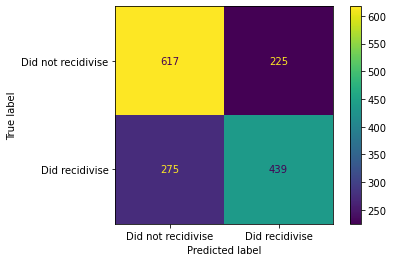

In [185]:
plot_confusion_matrix(tuned_xgb,
                     X_test,
                     y_test,
                      values_format='d',
                     display_labels=["Did not recidivise","Did recidivise"])

### RANDOMIZED SEARCH CV

SECOND TRY

In [186]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 10, 5]
        }

In [187]:
# timer
from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [188]:
xgb = XGBClassifier(learning_rate=0.002, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [189]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

folds = 5
param_comb = 35

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 35 candidates, totalling 175 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:34:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:34:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 2 minutes and 57.42 seconds.


In [224]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([1.21443677, 2.46395135, 2.74150538, 2.7998909 , 9.59068956,
       5.43175159, 2.89349952, 2.20963259, 3.60638838, 7.83084998,
       9.8335598 , 1.99784212, 3.59710283, 3.61725259, 3.82185531,
       6.38367581, 7.10856643, 7.20157003, 9.66298642, 3.96771126,
       8.28509192, 1.67945981, 2.51677299, 1.25748005, 1.81036844,
       4.24872365, 3.26550918, 3.91484504, 8.11182446, 2.00598006,
       6.89083633, 2.74469042, 2.74357171, 3.91838021, 4.44918556]), 'std_fit_time': array([0.01430042, 0.02681344, 0.49318517, 0.05567532, 0.78141135,
       0.04353781, 0.13231908, 0.05476383, 0.080326  , 0.63007167,
       0.1070945 , 0.15511119, 0.06670508, 0.12343445, 0.16585291,
       0.06016323, 0.09836936, 0.13852463, 0.15373019, 0.1288854 ,
       0.50252846, 0.12007398, 0.02017929, 0.00980903, 0.10322445,
       0.19597014, 0.19534155, 0.09118573, 0.35259606, 0.05860871,
       0.43899848, 0.07116749, 0.37480487, 0.22622921, 0.35474669]), 'mean_sco

In [194]:
tuned_xgb2 = XGBClassifier(seed=42, 
                          max_depth = 10,
                          min_child_weight = 2,
                          gamma = 1.5,
                          subsample = 0.8,
                          colsample_bytree = 1)

In [191]:
tuned_xgb2.fit(X_train,
              y_train,
              verbose=True,
             early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.64092
[1]	validation_0-aucpr:0.65367
[2]	validation_0-aucpr:0.67999
[3]	validation_0-aucpr:0.68567
[4]	validation_0-aucpr:0.68910
[5]	validation_0-aucpr:0.68689
[6]	validation_0-aucpr:0.68391
[7]	validation_0-aucpr:0.68920
[8]	validation_0-aucpr:0.69111
[9]	validation_0-aucpr:0.69075
[10]	validation_0-aucpr:0.69021
[11]	validation_0-aucpr:0.68536
[12]	validation_0-aucpr:0.68603
[13]	validation_0-aucpr:0.68418
[14]	validation_0-aucpr:0.68424
[15]	validation_0-aucpr:0.68506
[16]	validation_0-aucpr:0.68314
[17]	validation_0-aucpr:0.68502
[18]	validation_0-aucpr:0.68154


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1.5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [192]:
acc = tuned_xgb2.score(X_test, y_test)
print(acc*100)

66.51670951156812


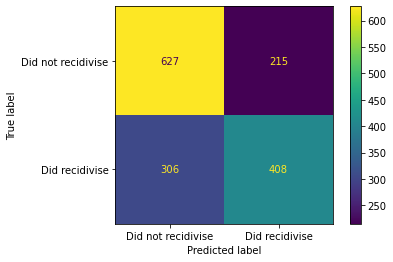

In [193]:
plot_confusion_matrix(tuned_xgb2,
                     X_test,
                     y_test,
                      values_format='d',
                     display_labels=["Did not recidivise","Did recidivise"])

END OF NOTEBOOK